## Monte Carlo Methods to Estimate and Optimize PageRank
#### EN.553.433 Monte Carlo Methods: Final Project
#### Viggy Vanchinathan, May 2025

__Abstract__: PageRank is arguably the single most important algorithm of the modern Information age, generating billions in revenue for Google and changing the way we interacted with the Internet forever. Despite it's reach, the algorithm is remarkably simple, essentially modeling the millions of pages on the World Wide Web as a Markov Chain, and ranking pages based on their normalized probability in it's stationary distribution. Here, we demonstrate the use of Monte Carlo methods to estimate PageRank on a few examples, with a few extension points for optimization of the algorithm. 

__Introduction__

PageRank was introduced in the seminal 1998 whitepaper: *The PageRank Citation Ranking: Bringing Order to the Web*. In the 90s, the number of webpages on the World Wide Web was growing exponentially doubling every year, leading to an increased demand for an intuitive, accurate, and fast way to search for relevant content. There were manual indexes of sites maintained (such as Yahoo), but, because they were manual, were cumbersome and slow to update. Search engines were tools build to query the wealth of pages being indexed. Many (such as Altavista) existed, but often failed to return results that matched the search query. 

Lawrence Page, Sergey Brin, Rajeev Motwani, and Terry Winograd, Computer Science PhDs, introduced a new and improved search engine, Google, alongside a new algorithm they used to rank the importance of webpages effectively, PageRank. This algorithm alone won them a competitive spot in the "Browser War" of the early 2000s, catapulting them to fame. Today, Alphabet, the parent holding company of Google, is worth approximately $1.84 trillion dollars.


### Suboptimal Centrality Measures
How do we measure page importance?

The setup:

Let the internet be a directed graph $G=(V, E)$, with each independent webpage as a node in $V$, and hyperlinks from one page to another as a directed edge in $E$ between the nodes. Links leaving a page are "outedges", and links arriving at a page are "inedges". We need a way to measure the importance of a webpage, so that it can come up near the top of a search query. 

One intuitive option is to use **Degree Centrality** as a measure of importance. The importance of a node v is: $$I(v) = deg(v)$$

Intuitively, the number of other nodes connected to v.

In [122]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx

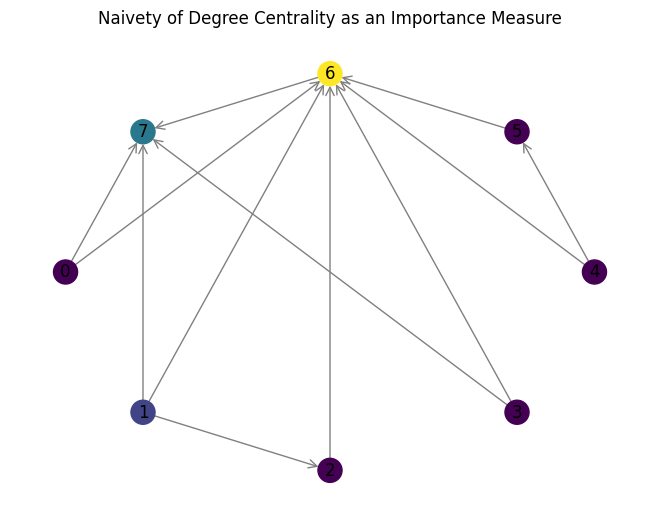

In [123]:
#demonstrating the flaws with counting edges (Degree Centrality)

adj_matrix_naive = np.array([
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 1, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

graph_naive = nx.from_numpy_array(adj_matrix_naive, create_using=nx.DiGraph)
dc = nx.degree_centrality(graph_naive)

# 4. Draw the graph
pos = nx.shell_layout(graph_naive)
nx.draw(graph_naive, pos, with_labels=True,
        node_color= list(dc.values()),
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

plt.title("Naivety of Degree Centrality as an Importance Measure")
plt.show()

Notice that page 6 and 7 have the highest importance in this graph, but that there is no way to weight the importance a single edge. An inedge from many reputable sources should contribute more to the centrality measure than the same number of inedges from dubious sources. 

Additionally, actors interested in boosting visibility to their site may attempt to game the metric by artificially increasing inedges to their site by generating fake pages. We need a new measure that weights incoming edges by the importance of the departure node.

One way to combat this is to use another measure of importance, one that depends more on the importance of the nodes that connect to it. One such measure is **eigenvector centrality**, which is defined as a vector $x$ such that:
$$x_v = \frac{1}{\lambda} \sum_{t \in V} a_{vt} x_t$$

which rearranges down to the regular eigenvector equation:

$$Ax = \lambda x$$

Intuitively, the vector of centrality measures for each node is just the corresponding term in the eigenvector with the highest eigenvalue.


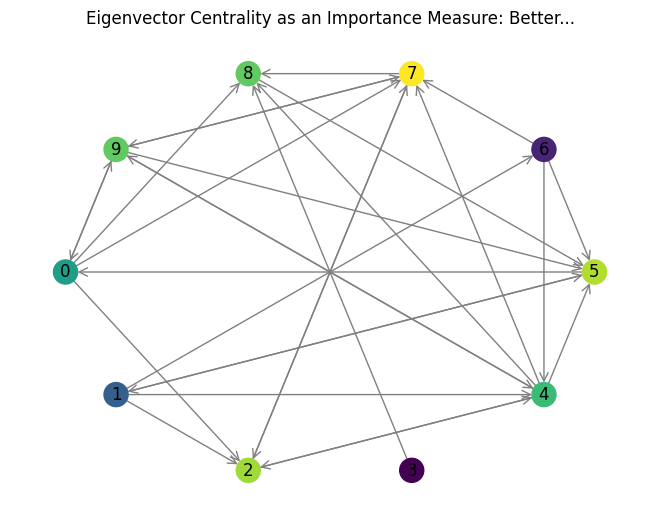

In [124]:
#demonstration of eigenvector centrality

graph_ev = nx.gnp_random_graph(n=10, p=0.3, directed=True, seed=101)
ev = nx.eigenvector_centrality(graph_ev)

# 4. Draw the graph
pos = nx.shell_layout(graph_ev)
nx.draw(graph_ev, pos, with_labels=True,
        node_color= list(ev.values()),
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

plt.title("Eigenvector Centrality as an Importance Measure: Better...")
plt.show()

This does a better job of assigning importance to nodes that are connected to other important ones. Page 3 is of very low importance, because it does not connect to any more high-profile pages besides 8, and has no "hyperlinks"/edges to it. Not also the difference between Pages 6 and 1, which have the same degree. However, 1 is pointed to by 5, and 6 is pointed to by only 1. 5 is more important than 1, so it makes sense that Page 1 is more important than Page 6.

How can we calculate the rank of a node if we need to know the rank of another node first? #TODO add power iteration visual to calculate eigenvalue  

We define a simplified version of PageRank based on eigenvalue centrality. It's essentially the same thing. The ranking $R$ is:
$$ R(u) = c \sum_{v \in B_u} \frac{R(v)}{N_v} $$

Where $B_u$ is the set of backlinks to node $u$ (i.e. all the pages that point to $u$), $N_v$ is the number of edges out of node $v$, $R(v)$ is the ranking of node $v$, and $c$ is a normalization factor so that the sum of all ranks is 1. Intuitively, the ranking of a node is the sum of the weighted contributions from the nodes that connect to it. More important nodes mean a higher rank. Also note that this is a recursive/circular definition.

### Markovian Properties of WWW: Simplified PageRank

We understand that because we travel from one site to the next based on page links, a random walk along this graph is **Markovian**. We also may have multiple links from one site to another, introducing weighted edges into our graphs. We can attempt to find the **stationary distribution** of the markov chain by repeatedly applying the transition matrix to the matrix of ranks. The transition matrix will need to be normalized to the rows.

In [125]:
N = 100
n = 10  #number of nodes
max_iters = N

eps = 1e-6 #threshold to mark convergence

In [126]:
#perform single update of ranks
def update(ranks, g):
        adj = nx.to_numpy_array(g)
        assert len(ranks) == len(adj), "Distribution length must match number of nodes"  
        s = adj.sum(axis =1, keepdims = True)
        s = np.where(s==0, 1, s) #replace 0s w 1s to avoid dividebyzero errors
        norm_adj = adj / s
        return ranks @ norm_adj

#return total variational distance
def tvd(prev_rank, curr_rank):
        assert len(prev_rank) == len(curr_rank), "rank vectors must be same length"
        return 0.5 * np.sum(np.abs(curr_rank - prev_rank))


Text(0.5, 1.0, 'Total Variational Distance between Rank Vectors')

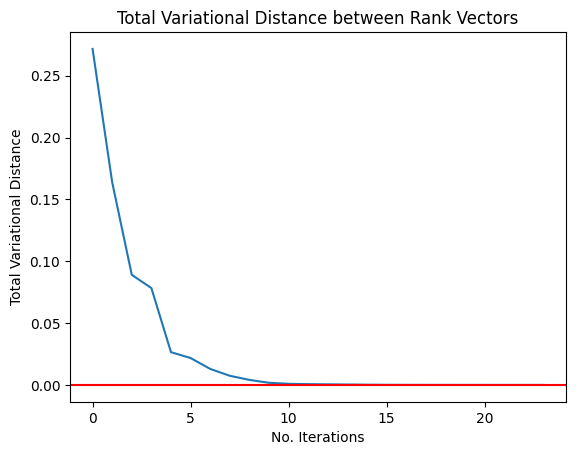

In [127]:
rank = np.full(n, 1/n)
no_it = 0
tvds = []
tvd_it = eps + 1 #init above eps to enter loop

#test convergence for connected example.
while tvd_it > eps and no_it < 100:
    new_rank = update(rank, graph_ev)
    tvd_it = tvd(prev_rank=rank, curr_rank=new_rank)
    tvds.append(tvd_it) #keep track of tvds for plotting
    rank = new_rank
    no_it += 1
    
plt.plot(np.arange(0, len(tvds), 1), np.array(tvds))
plt.axhline(eps, color = "red")
plt.xlabel("No. Iterations")
plt.ylabel("Total Variational Distance")
plt.title("Total Variational Distance between Rank Vectors")

Now that we have a converged rank vector, let's compare it to the earlier eigenvector similarity metric. We should get similar values...

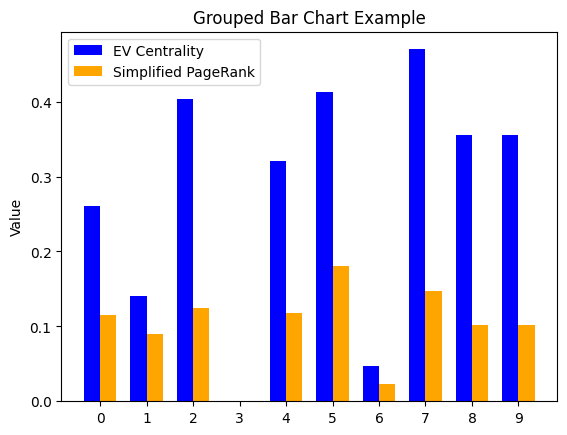

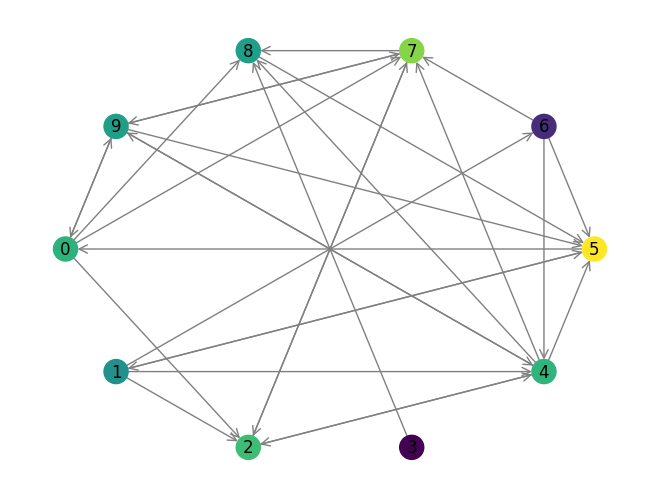

In [128]:
x = np.arange(n)
width = 0.35

plt.bar(x - width/2, ev.values(), width, label='EV Centrality', color='blue')
plt.bar(x + width/2, rank, width, label='Simplified PageRank', color='orange')

# Labeling
plt.xticks(x)
plt.ylabel('Value')
plt.title('Grouped Bar Chart Example')
plt.legend()

plt.figure()
nx.draw(graph_ev, pos, with_labels=True,
        node_color= rank,
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

Our rank vector converged to a stationary distribution, and the rank intensities do look similar to the EV metric. However this randomized graph is a toy model of the real web. Recall that to have a guaranteed stationary distribution we need to have an **ergodic** graph, i.e. the graph is
1. (A) aperiodic
2. (B) irreducible.

However, this may not necessarily be true. Two webpages may have links to each other, removing aperiodicity. There may also be sections of webpages that are siloed from others. The actual graph of the web is highly disconnected. What happens when we attempt this measure of centrality on a disconnected graph?

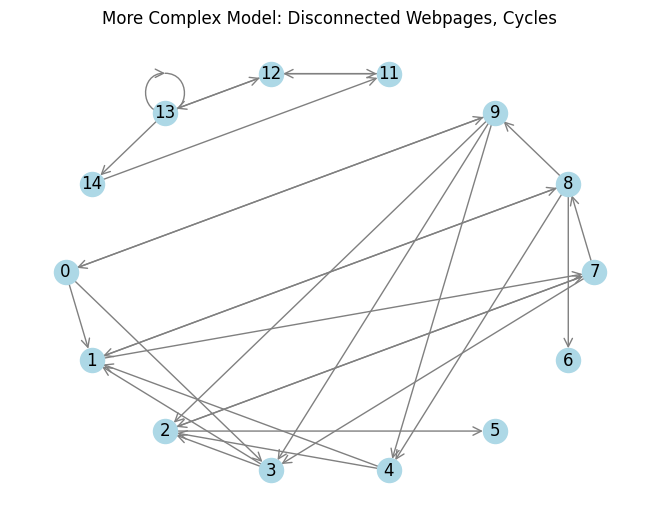

In [131]:
#demonstration on more complex graph model

graph_web = nx.gnp_random_graph(n=10, p=0.3, directed=True, seed=102)
graph_web.add_edges_from([(11, 12), (12, 11), (13, 12), (13, 13), (14, 11), (13, 14), (12, 13)])

# 4. Draw the graph
pos = nx.shell_layout(graph_web)
nx.draw(graph_web, pos, with_labels=True,
        node_color= "lightblue",
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

plt.title("More Complex Model: Disconnected Webpages, Cycles")
plt.show()

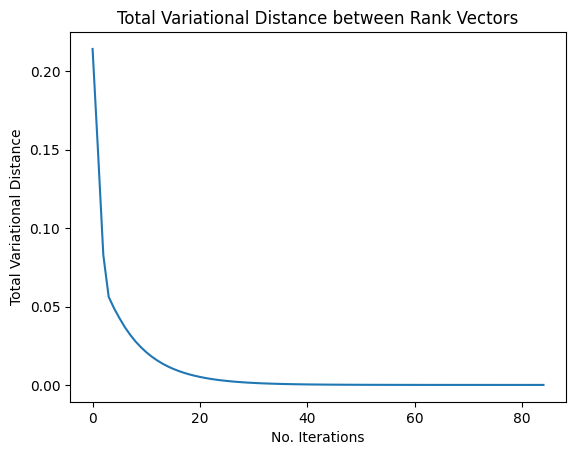

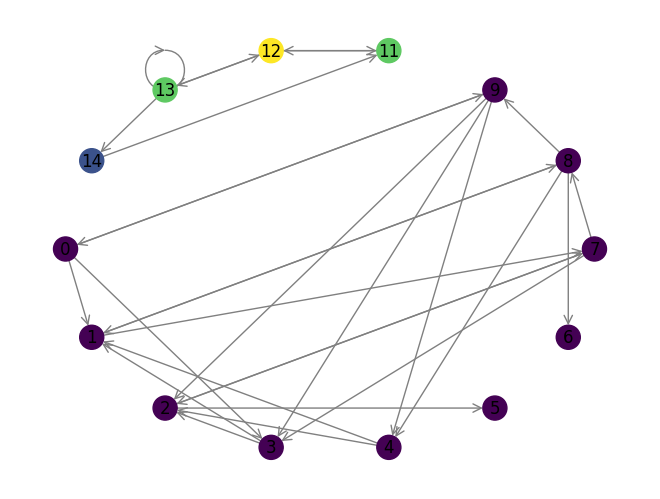

In [132]:
rank = np.full(n+4, 1/(n+4))
no_it = 0
tvds = []
tvd_it = eps + 1 #init above eps to enter loop

#test convergence for connected example.
while tvd_it > eps and no_it < 100:
    new_rank = update(rank, graph_web)
    tvd_it = tvd(prev_rank=rank, curr_rank=new_rank)
    tvds.append(tvd_it) #keep track of tvds for plotting
    rank = new_rank
    no_it += 1

    
plt.plot(np.arange(0, len(tvds), 1), np.array(tvds))
plt.xlabel("No. Iterations")
plt.ylabel("Total Variational Distance")
plt.title("Total Variational Distance between Rank Vectors")

plt.figure()
nx.draw(graph_web, pos, with_labels=True,
        node_color= rank,
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

Although the rank converged, we noticed that all pages disconnected from the topic pocket have 0 rank. Our graph is clearly not ergodic, and so we are not guaranteed a viable stationary distribution here. We have nodes with no outedges (i.e. webpages with no hyperlinks), nodes connected to themselves (homepages with links to themselves, perhaps), and pages disconnected from the rest of the network. To combat we augment our simplified PageRank with additional considerations.

### Random Surfer Model

To get around these concerns, we use the **Random Surfer Model**, which models a generic user traversing the web graph. A user will start on a random starting page, and will "surf" the web graph by clicking links. This should remind us of the Markovian property, the next page the user will end up at is dependent only their current page and its links. Additionally, we can assume that the random surfer will not stay in engaged in group of pages that link only to each other. This shoudl remind us of the **Simulated Annealing** algorithm. At any given step, there is a chance that the surfer will jump to another random page on the graph. This ensures that probability mass moves through all pages, even though there are disconnected and cyclical components.

### PageRank

We add another vector $E$ to the rank calculation that allows us to jump to other disconnected nodes. This ensures that every node is accessible (enforcing irreducibility), and it also eliminates any cycles, because the random surfer could jump to another node at any iteration  (enforcing aperiodicity). The graph is now ergodic, guaranteeing a stationary distribution for our rank calculation. The new rank is:

$$R(u) = c \sum_{v \in B_u} \frac{R(v)}{N_v} + cE(u)$$

In matrix form:

$$ R = c(AR + E) $$

We also add an additional factor that encourages the graph to move to unexplored areas. This serves as a damping factor. Google uses 0.85. The final algorthm:

1. Initialize starting rank vector, $R_0$
2. while $tvd$ < $\epsilon$
3.    $R_{i+1} = R_i * A$
5.    $R_{i+1} = \alpha R_{i+1} +  (1-\alpha) E$
6.    $tvd = TotalVariationalDistance(R_{i+1}, R_i)$

\* norms are L1 here

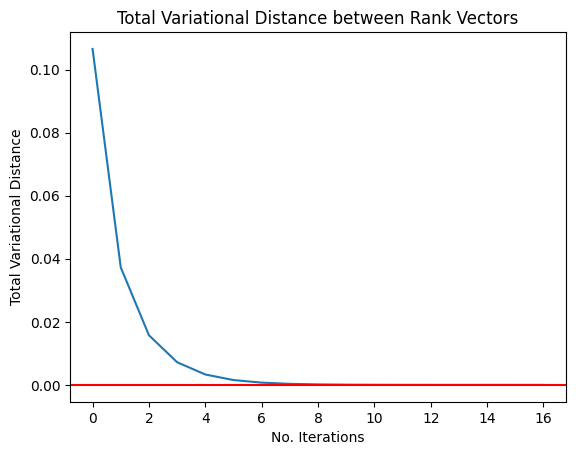

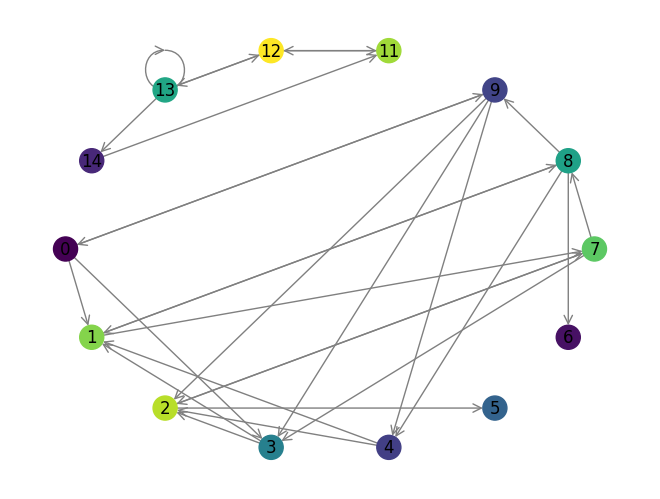

In [148]:
rank = np.full(n+4, 1/(n+4))
E = np.full(n+4, 1/n) #uniform teleportation

no_it = 0
tvds = []
tvd_it = eps + 1 #init above eps to enter loop
alpha = 0.50

#test convergence for connected example.
while tvd_it > eps and no_it < 100:
    new_rank = alpha * update(rank, graph_web)
    new_rank += (1-alpha) * E
    tvd_it = tvd(prev_rank=rank, curr_rank=new_rank)
    tvds.append(tvd_it) #keep track of tvds for plotting
    rank = new_rank
    no_it += 1

plt.plot(np.arange(0, len(tvds), 1), np.array(tvds))
plt.axhline(eps, color = "red")
plt.xlabel("No. Iterations")
plt.ylabel("Total Variational Distance")
plt.title("Total Variational Distance between Rank Vectors")

plt.figure()
nx.draw(graph_web, pos, with_labels=True,
        node_color= rank,
        edge_color='gray',
        arrows=True,
        arrowstyle='->',
        arrowsize=15)

#### References
1. [The PageRank Citation Ranking: Bringing Order to the Web](https://www.cis.upenn.edu/~mkearns/teaching/NetworkedLife/pagerank.pdf) (original technical whitepaper written by Lawrence Page, Sergey Brin, Rajeev Motwani, and Terry Winograd)
2. [The Anatomy of a Large-Scale Hypertextual Web Search Engine](https://snap.stanford.edu/class/cs224w-readings/Brin98Anatomy.pdf) (paper introducing Google Search Engine itself)
3. [How we got from 1 to 162 million websites on the Internet](https://www.pingdom.com/blog/how-we-got-from-1-to-162-million-websites-on-the-internet/)
4. [Browser Wars (Wikipedia)](https://en.wikipedia.org/wiki/Browser_wars)
5. [Centrality Measures (Wikipedia)](https://en.wikipedia.org/wiki/Centrality)
6. [Perron-Frobenius Theorem (Wikipedia)](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem)
7. [Understanding Page Rank (Medium Blog)](https://medium.com/@sarthakanand/page-rank-b7072c61dd85)

I also watched a few YouTube videos to make sure my intuitive understanding lined up with the more formal setup:

[x] [How Google's PageRank Algorithm Works](https://youtu.be/meonLcN7LD4?si=K8h-H7--f47u5bOB)
